## Evaluation code for DIFF2 paper
### Usage
1. run source_code/scripts/reproduction.sh to get {exp_name} folder that contains the experimental results (see README.md in source_code).
3. Run the following scripts (folder "figs" will be generated).

In [5]:
import os
import pickle
import copy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import scipy.stats

In [6]:
# If you want to evaluate train loss or test loss, choose 0, otherwise choose 1
tuning_metrics = ["train_loss", "train_grad_norm"]
tuning_metric = tuning_metrics[0] 

def search_best_results(files, work_dir):
    min_train_loss_lst = []
    for file in files:
        with open(os.path.join(work_dir, file), "rb") as f:
            results = pickle.load(f)
        results = results[np.min(list(results.keys()))]
        if np.isnan(np.min(results[tuning_metric])):
            min_train_loss_lst.append(np.inf)
        else:
            min_train_loss_lst.append(np.min(results[tuning_metric]))
    best_file = files[np.argmin(min_train_loss_lst)]
    with open(os.path.join(work_dir, best_file), "rb") as f:
        best_results = pickle.load(f)
    best_results = best_results[np.min(list(best_results.keys()))]
    return best_results, best_file

In [16]:
exp_name = "test"

# Choose dataset
dataset_names = ["california_housing"]
dataset_name = dataset_names[0] 

model_name = "fc_10"
seeds = [0]

eps_lst = [0.6, 0.8, 1]
all_metrics = ["train_loss", "train_grad_norm", "test_loss", "test_grad_norm"]

In [17]:
saved_results = {(eps, seed): {met: None for met in all_metrics} for eps in eps_lst for seed in seeds}
for eps in eps_lst:
    if (eps == None):
        continue
    for seed in seeds:
        work_dir = f"results/{exp_name}/{model_name}/{dataset_name}/eps_{eps}_delta_1e-08/seed_{seed}/ce_plsgm"
        all_files = os.listdir(work_dir)
        files = [file for file in all_files]
        best_results, best_file = search_best_results(files, work_dir)
        for met in all_metrics:
            saved_results[(eps, seed)][met] = best_results[met]

In [18]:
def get_metric_name_for_plot(metric):
    if eval_metric == "train_loss":
        return "Train Loss"
    elif eval_metric == "train_grad_norm":
        return "Train Grad. Norm"
    elif eval_metric == "test_loss":
        return "Test Loss"
    elif eval_metric == "test_grad_norm":
        return "Test Grad. Norm"
    else:
        assert False
        
def get_dataset_name_for_plot(dataset_name):
    if dataset_name == "california_housing":
        return "CA Housing"
    elif dataset_name == "gas":
        return "Gas Turbine"
    elif dataset_name == "blog":
        return "BlogFeedback"
    else:
        assert False

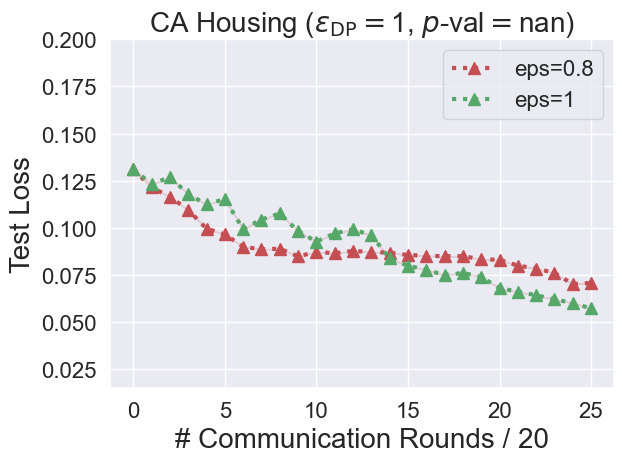

In [22]:
# Choose evaluation metric
eval_metrics = ["train_loss", "train_grad_norm", "test_loss"]
eval_metric =  eval_metrics[2] 

if eval_metric == "train_grad_norm":
    assert tuning_metric == "train_grad_norm"
if tuning_metric == "train_grad_norm":
    assert eval_metric == "train_grad_norm"

if "loss" in eval_metric or "grad_norm" in eval_metric:
    eval_func = np.min
elif "acc" in eval_metric:
    eval_func = np.max

sep = 1
colors = ["r", "g", "b"]
for eps, color in zip(eps_lst[1:], colors): 

    means = np.mean([saved_results[(eps, seed)][eval_metric] for seed in seeds] 
                    , axis=0)[::sep]
    stds = np.std([saved_results[(eps, seed)][eval_metric] for seed in seeds] 
                    , axis=0)[::sep]

    plt.plot(range(len(means)), means, marker="^", ms=9, lw=3, ls="dotted", label=f"eps={eps}", color=color)
    plt.fill_between(range(len(means)), means - stds, means + stds, color='r', alpha=0.2)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel(f"# Communication Rounds / {20*sep}", fontsize=20)
    plt.ylabel(get_metric_name_for_plot(eval_metric), fontsize=20)
    
    data = [eval_func(np.array(saved_results[(eps, seed)][eval_metric]))
                  - eval_func(np.array(saved_results[(eps, seed)][eval_metric]))
                              for seed in seeds] 
    p_val = scipy.stats.ttest_1samp(data, 0, alternative="less").pvalue

    plt.title(get_dataset_name_for_plot(dataset_name) 
              + r" ($\varepsilon_\mathrm{DP}=$" + f"{eps}, " + r"$p$-val$=$" + f"{round(float(p_val), 2)})"
              , fontsize=20)
    if tuning_metric == "train_grad_norm":
        plt.yscale("log")
    else:
        if dataset_name == "california_housing":
            ylim_l, ylim_u = 0.015, 0.2
        elif dataset_name == "gas":
            ylim_l, ylim_u = 0.0009, 0.0013
        elif dataset_name == "blog":
            ylim_l, ylim_u =  0.0002, 0.004 
        plt.ylim(ylim_l, ylim_u)
    plt.tight_layout()

save_dir = f"figs/{dataset_name}/{model_name}"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
plt.savefig(os.path.join(save_dir, f"{eval_metric}.png"))
plt.show()
plt.close()